# Assignment #3 - Reinforcement Learning

### 

<font color="blue">Ali Mahzarnia </font>

# I. Overview

In this assignment, we try to implement the reinforcement learning to find the right path in a maze.

# II. Problems 

## A. Maze Problem (Practice)

Description of maze problem:
In this problem we first set a fixed maze, (Four outside walls, and some inside wall, a starting point and a goal). We let the random decision lead the way for multiple times. We reward getting close to goal , and we heavily punish hitting the wall by negative infinity reward. The transition matrix, which is updated through the many simulations can help us to find the maze from a new starting point. To update the transition matrix Q we can take Q learning or SARSA approach.

In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [2]:
%%bash 
cat grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO

### GridWorld Class


In [3]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

Explanation of the GridWorld:

We need to set award and punishment for our problem solving method. There are 4 randomly steps that can be taken at each grid or state. L,R,U,D. We set a punishment -1 for each step, because we want to choose the shortest step at the end.

First thing is a reader. We need to read the map, and see what is the size of map (two dimensions) and determine the state of goal on the map.

Also we need to define the random actions by their vector representatives. 

We need to define a function that checks the current state after each random action, if it is outside the walls, inside and inside a hole, inside and in an empty spot, or on the goal.

Then we check if the state is inside the map, with another function. We need a function to check so if the current state is outside the 4 outside walls, its axis element is either below zero or bigger than the size of map.

We need initializer, which put us in (0,0) position of the map if the initial state is not already defined. Also, if our initial input state is out side of the wall, we should not allow the input.

With a function (next) we just go to next step by adding the arbitrary step to the current state.

Here the rewards are determined. If our next step goes to a wall or outside of a wall penalize -5, other wise if we are at goal we reward +30, and if not goal but a free state penalize -1.



In [5]:
import collections
env = GridWorld("grid.txt")
env.print_map()
env.check_state([2,3])
env.init([0,0])
env.next(1)

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


-1

All commands checked and works well.

The following command takes the state to the top left of coordinator.

In [6]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

# Methods


Review of the SARSA and Q-Learning :


Q is the transition matrix we have to update it at each simulation. Q tells us what is the probability of being at one state and taking a particular action and go to other state based on the reward system. We usually take the maximum probability among all of the simulations in Q (Note Q has a time dimension through many simulations), and we chose the action with the highest probability.


To update with  **SARSA**. method:

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

Where $s_t$ is the current state at time $t$, $\alpha, \gamma$ are parameters, and $a_{t}$ is action at time $t$, and $R_{t}$ is a reward at time $t$ for that particular simulation. 

or **Q-learning**. 


$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

Here describes each algorithm. 


**[Algorithm: TD Learning]**
![](http://incompleteideas.net/book/ebook/pseudotmp7.png)

**[Algorithm: SARSA]**
![](http://incompleteideas.net/book/ebook/pseudotmp8.png)


**[Algorithm: Q-learning]**
![](http://incompleteideas.net/book/ebook/pseudotmp9.png)








- Decide your TD learning approach: SARSA or Q-learning? 

I decide to use SARSA for simplicity in the algorithm. I think the complexity of algorithm would go higher if I chose Q-learning due to finding the maximum of Q after n simulation which is O(n), and it would be time consuming.

- Describe your approach and the reason why you select it.

So I update my Q with SARSA after many simulations and at the end I have the updated Q and I can test it.
About the maze the state is clear as defined and explained in Gridworld. The reward is also clearly explained as -1,30,-5,....
 

- Finish epsilon_greedy function and other TODOs. Explain it.

In epsilon greedy, we chose a random number between 0 and 1. We have a fixed epsilon as threshold, and if our chosen number is greater than the epsilon we find the argument of the maximum probability of Q, through the simulations. This will give us the most probable action should be taken through all of the simulations with respect to rewards.

Code is completed.

- Explain your codes.

In the following:



## RLAgent for Maze

Read the understand the codes below and explain it with your words. 
Do NOT forget to answer the question. 

We have an agent class which takes random actions in the maze env.

We start our transition matrix with Q=0 matrix.

The epsilon greedy function as explained  above finds the argmax of the Q through the simulation for a particular  state and tells us after all of these simulation where should we go with high probability to get better reward.


Parameters  for Sarsa are fixed (will be explained later).

We need to keep track of our reward (rtrace), and steps and trace.

So we run many iterations and we take random actions and with respect to the reward and action we took we update our Q over and over again at each simulations.

We should know at state (2,3) what is the most probable  action to be taken and get the most reward. For example it is "up".


At the end when we trained through the simulation and updated our Q, we test our policy by simply a test function that changes the starting point (with initializer) and using the updated Q ties to get to maze.




### Answer to the question in the code: 

The question is why Q is update as 0 when we are at goal. It is obvious that we do not want to go any where else when we get to goal so Q for the state of goal should be zero for any action or no action should be taken from there.



In [7]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
    
    def epsilon_greed(self, epsilon, s):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            #print(np.argmax(self.Q[s]),self.Q[s])
            #print(np.argmax(self.Q[s[0],s[1],:]),self.Q[s[0],s[1],:])
            return np.argmax(self.Q[s[0],s[1],:])
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        
        for j in range(maxiter):

            self.env.init(start)
            s = self.env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = self.env.next(a)
                s1 = self.env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))
                #print(alpha * (r + gamma * self.Q[s1[0],s1[1], a1] - self.Q[s[0],s[1],a]))
                #print(self.Q[s[0],s[1], a] )
                #print(a,a1)
                self.Q[s[0],s[1], a] += alpha * (r + gamma * self.Q[s1[0],s1[1], a1] - self.Q[s[0],s[1],a])
                #break
      
               
                if self.env.is_goal(): # reached the goal
                    # TODO: Why is this zero? Describe this in your code explanation.
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
            #print(goal)
            #print('>>',steps)
            #print(self.Q)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
       # for j in range(1):
        epsilon=0.1
        self.env.init(start)
        s = self.env.get_cur_state()
        a = self.epsilon_greed(epsilon, s)
        rewards = []
        trace = np.array(coord_convert(s, self.size))
        for step in range(maxstep):
                r = self.env.next(a)
                s1 = self.env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)
                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))
                
                if self.env.is_goal():
                    #self.Q[s1[0], s1[1], a1] = 0
                    break
                    
                s = s1
                a = a1
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 

        return trace            

The following is to find the best parameters. I have decreased the maxstep till I found that the goal can be achieved by setting maxstep as lowest as 50 as well.
Goal achieved if that number at the end is 20 which is the reward of smallest number of steps. 
!!


In [8]:
agent = RLAgent(env)
start = [0,0]
a=agent.train(start, 
                                   gamma=0.9, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=50)
a[0][np.argmin(a[1])]# this is goal achieved if it is 20 and 


20

# IV - Results maze

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 

* $\gamma$ : a discount factor initially  it is 0.99

* $\alpha$ : controls how much the temporal difference affect our updating here is initially  0.1

* $\epsilon$ : initially  is 0.1, this is the parameter of $\epsilon$ greedy function when we want to see if a random  number between 0 and 1 is less than this or not. If that random number is bigger than epsilon  we chose the argmax of Q matrix. If that number  is smaller than epsilon we chose the maximum of the size as the action (last action).


*  maxiter : number of simulations through which we update the Q

* maxstep : we limit the number of steps taken to get to goal. Otherwise any policy with unlimited  steps can get to goal and stay there forever.







  - Run experiments to find good parameters
  
  Done below: so I assume after many times running from one of the plots the following set of parameters is good enough and work as fine as others.
  
  
  
  - Show the experimental outputs to show the process of your selection
  
  above done: maxstep is 20
  
- Visualize the results and explain outputs (even from mine.)
below

### Utility functions for Plotting

- We simply finish the plotting tools to see the results.

In [9]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    
    

    
def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    #print(rtrace)
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    plt.plot(steps)
    
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

### Training and Testing with GridWorld

Experimental outputs

In [26]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.9, 
                                   alpha=0.1, 
                                   epsilon=0.05, 
                                   maxiter=10000, 
                                   maxstep=50)

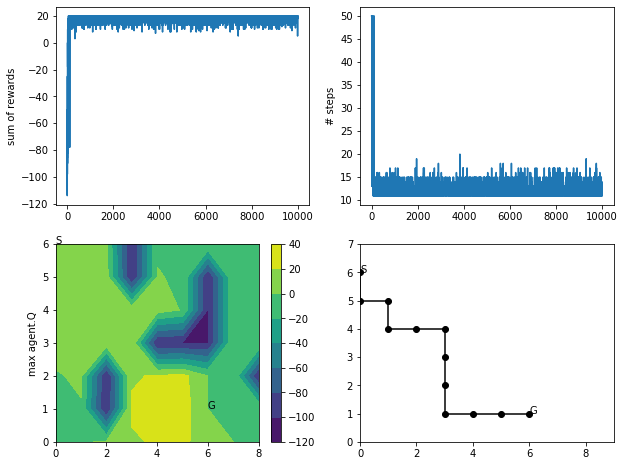

In [27]:

plot_train(agent, rtrace, steps, trace, start)

reading and analysis of learning results 

In training (starting at 0,0) we see as we predicted maxstep 50 is good enough. 

The plots :

1st plot top left : shows sum of the reward goes to 20 when we get to 100 iteration which is desired number (20). (30 of goal- 10 steps)

2nd plot top right : shows number of steps till we got stable and get to goal.

the two other plots just show the policy result after simulations. 



In the following we test if the trained Q can find the goal staring from different points.

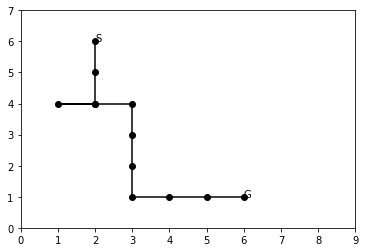

In [29]:
test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

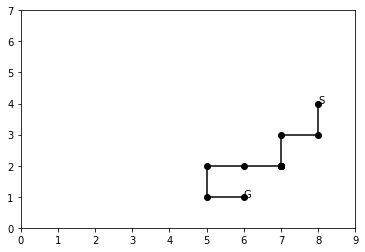

In [30]:
test_start = [2,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

# V. Conclusions

The main challenge is to define the state and Q in different problems.the updating process looks easy once we determine the reward.

Sometimes the higher learning rate does not show a good result in terms of being stable and higher epsilon shows a fluctuating path. 

The reinforcement learning is the use of probability transition matrix in terms of finding the maximum probable action through many iterations ( maximum probability based on the reward system). This can be used in many areas like robot walking and auto-driving I assume.


